# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

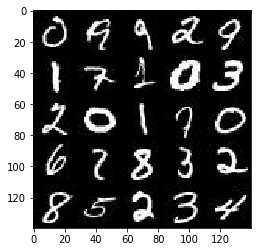

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

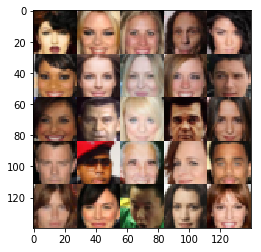

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='inputs_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [6]:
# some hyperparameters as global variables
alpha = 0.1  # leaky ReLU
filter_size = 5  # filter size

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
# As the original image are 28x28, we can only use 2 convolutional layers with a stride of 2 
# (down to 14x14 then 7x7. we cannot go futher as 7 is odd)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # first layer: convolution + lrelu (no batch normalization)
        # Input layer is 28x28x[1 or 3]
        x1 = tf.layers.conv2d(images, 64, filter_size, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # now 14x14x64
        
        # 2nd layer: convolution + batch normalization + lrelu
        # Input layer is 14x14x64
        x2 = tf.layers.conv2d(relu1, 128, filter_size, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        # third layer: convolution + batch normalization + lrelu
        # Input layer is 7x7x128
        x3 = tf.layers.conv2d(relu2, 256, filter_size, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * x3, x3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # reuse weights when infering (not training), reuse is the logical not of training
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, filter_size, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, filter_size, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # no batch norm nor activation in the last layer of generator
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # generator
    g_model = generator(input_z, out_channel_dim)
    # g_model is the generator output

    # real discriminator model: input real images
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    
    # fake discriminator model: input from generator but reuse same weights
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # discriminator real loss: logits from real model, labels = 1 (and label smoothing)
    # I used one-sided label smoothing 
    # (only on real images label as recommended by https://github.com/aleju/papers/blob/master/neural-nets/Improved_Techniques_for_Training_GANs.md)
    smooth = 0.1   
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels= tf.ones_like(d_logits_real) * (1 - smooth)))
    
    # discriminator fake loss: logits from fake model (input from generator), labels = 0
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_logits_fake)))
    # total disciminator loss
    d_loss = d_loss_real + d_loss_fake

    # generator loss: logits from fake discriminator and labels equal to one (to fool the disciminator)
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels= tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update for discriminator and generator
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize using Adam
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    channel_dim = data_shape[3]
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], channel_dim, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, 
                                                     inputs_z: batch_z,
                                                     lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images,
                                                     inputs_z: batch_z,
                                                     lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:                    
                    show_generator_output(sess, 25, inputs_z, channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3415... Generator Loss: 8.9829
Epoch 1/2... Discriminator Loss: 0.3293... Generator Loss: 5.9189
Epoch 1/2... Discriminator Loss: 0.9675... Generator Loss: 2.3746
Epoch 1/2... Discriminator Loss: 0.3785... Generator Loss: 4.3687
Epoch 1/2... Discriminator Loss: 0.4351... Generator Loss: 5.4669
Epoch 1/2... Discriminator Loss: 0.3723... Generator Loss: 4.3472
Epoch 1/2... Discriminator Loss: 0.4019... Generator Loss: 4.7026
Epoch 1/2... Discriminator Loss: 0.4133... Generator Loss: 4.0348
Epoch 1/2... Discriminator Loss: 0.3400... Generator Loss: 6.1175
Epoch 1/2... Discriminator Loss: 0.3389... Generator Loss: 6.7551


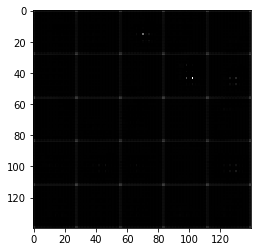

Epoch 1/2... Discriminator Loss: 0.3322... Generator Loss: 6.9131
Epoch 1/2... Discriminator Loss: 8.6557... Generator Loss: 15.6353
Epoch 1/2... Discriminator Loss: 0.7693... Generator Loss: 3.8533
Epoch 1/2... Discriminator Loss: 0.4192... Generator Loss: 3.2797
Epoch 1/2... Discriminator Loss: 2.1609... Generator Loss: 0.3242
Epoch 1/2... Discriminator Loss: 1.1876... Generator Loss: 5.0832
Epoch 1/2... Discriminator Loss: 0.4713... Generator Loss: 3.1980
Epoch 1/2... Discriminator Loss: 0.9712... Generator Loss: 1.6731
Epoch 1/2... Discriminator Loss: 0.7069... Generator Loss: 1.3691
Epoch 1/2... Discriminator Loss: 0.4945... Generator Loss: 2.7357


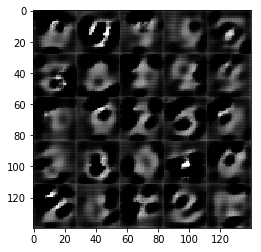

Epoch 1/2... Discriminator Loss: 0.4160... Generator Loss: 2.9198
Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 0.7071
Epoch 1/2... Discriminator Loss: 0.3880... Generator Loss: 3.5579
Epoch 1/2... Discriminator Loss: 0.4756... Generator Loss: 2.9625
Epoch 1/2... Discriminator Loss: 0.3991... Generator Loss: 3.6358
Epoch 1/2... Discriminator Loss: 0.3746... Generator Loss: 5.1635
Epoch 1/2... Discriminator Loss: 2.6399... Generator Loss: 5.6535
Epoch 1/2... Discriminator Loss: 0.4171... Generator Loss: 3.5414
Epoch 1/2... Discriminator Loss: 1.2253... Generator Loss: 1.1398
Epoch 1/2... Discriminator Loss: 0.5029... Generator Loss: 3.9716


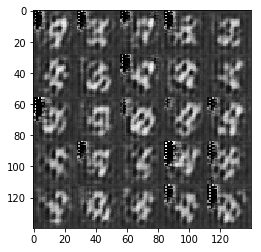

Epoch 1/2... Discriminator Loss: 0.5296... Generator Loss: 3.6373
Epoch 1/2... Discriminator Loss: 0.5226... Generator Loss: 2.9935
Epoch 1/2... Discriminator Loss: 0.4057... Generator Loss: 6.4003
Epoch 1/2... Discriminator Loss: 0.6548... Generator Loss: 4.6371
Epoch 1/2... Discriminator Loss: 0.7403... Generator Loss: 2.3772
Epoch 1/2... Discriminator Loss: 1.7329... Generator Loss: 0.5056
Epoch 1/2... Discriminator Loss: 1.0693... Generator Loss: 3.3163
Epoch 1/2... Discriminator Loss: 0.7996... Generator Loss: 2.7319
Epoch 1/2... Discriminator Loss: 0.7968... Generator Loss: 3.1583
Epoch 1/2... Discriminator Loss: 0.4527... Generator Loss: 4.4401


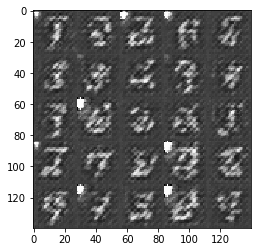

Epoch 1/2... Discriminator Loss: 0.4112... Generator Loss: 4.0131
Epoch 1/2... Discriminator Loss: 0.4951... Generator Loss: 3.1285
Epoch 1/2... Discriminator Loss: 0.7375... Generator Loss: 1.4685
Epoch 1/2... Discriminator Loss: 0.7746... Generator Loss: 2.5165
Epoch 1/2... Discriminator Loss: 0.5936... Generator Loss: 2.8499
Epoch 1/2... Discriminator Loss: 0.5416... Generator Loss: 2.6512
Epoch 1/2... Discriminator Loss: 0.5562... Generator Loss: 3.6667
Epoch 1/2... Discriminator Loss: 2.2703... Generator Loss: 0.9643
Epoch 1/2... Discriminator Loss: 0.6277... Generator Loss: 1.8695
Epoch 1/2... Discriminator Loss: 0.7541... Generator Loss: 2.6279


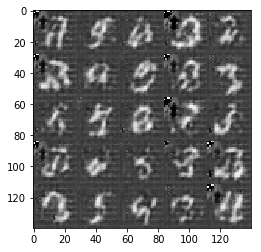

Epoch 1/2... Discriminator Loss: 0.5688... Generator Loss: 3.9303
Epoch 1/2... Discriminator Loss: 0.5113... Generator Loss: 4.8611
Epoch 1/2... Discriminator Loss: 0.7730... Generator Loss: 3.2871
Epoch 1/2... Discriminator Loss: 0.6194... Generator Loss: 3.3655
Epoch 1/2... Discriminator Loss: 0.6871... Generator Loss: 3.5869
Epoch 1/2... Discriminator Loss: 0.4232... Generator Loss: 4.9191
Epoch 1/2... Discriminator Loss: 0.4554... Generator Loss: 3.4143
Epoch 1/2... Discriminator Loss: 0.3935... Generator Loss: 4.0484
Epoch 1/2... Discriminator Loss: 0.4854... Generator Loss: 3.6192
Epoch 1/2... Discriminator Loss: 5.2183... Generator Loss: 0.0743


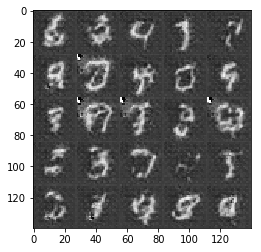

Epoch 2/2... Discriminator Loss: 0.8572... Generator Loss: 2.1327
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 1.7024
Epoch 2/2... Discriminator Loss: 0.7839... Generator Loss: 2.2000
Epoch 2/2... Discriminator Loss: 0.7572... Generator Loss: 2.3513
Epoch 2/2... Discriminator Loss: 0.6370... Generator Loss: 3.9152
Epoch 2/2... Discriminator Loss: 1.0060... Generator Loss: 3.0447
Epoch 2/2... Discriminator Loss: 0.7339... Generator Loss: 3.6410
Epoch 2/2... Discriminator Loss: 0.8688... Generator Loss: 2.0992
Epoch 2/2... Discriminator Loss: 0.5599... Generator Loss: 2.7247
Epoch 2/2... Discriminator Loss: 0.5464... Generator Loss: 3.1293


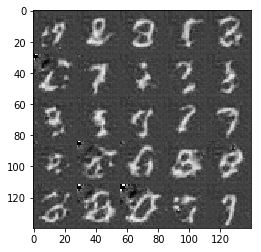

Epoch 2/2... Discriminator Loss: 0.6816... Generator Loss: 2.4559
Epoch 2/2... Discriminator Loss: 0.4101... Generator Loss: 5.2474
Epoch 2/2... Discriminator Loss: 0.4787... Generator Loss: 4.2179
Epoch 2/2... Discriminator Loss: 1.1948... Generator Loss: 2.8158
Epoch 2/2... Discriminator Loss: 0.7768... Generator Loss: 2.1097
Epoch 2/2... Discriminator Loss: 1.0802... Generator Loss: 1.6085
Epoch 2/2... Discriminator Loss: 0.6607... Generator Loss: 2.8119
Epoch 2/2... Discriminator Loss: 0.7419... Generator Loss: 3.2511
Epoch 2/2... Discriminator Loss: 0.6606... Generator Loss: 2.4426
Epoch 2/2... Discriminator Loss: 0.9506... Generator Loss: 2.1748


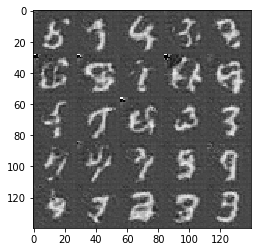

Epoch 2/2... Discriminator Loss: 0.5918... Generator Loss: 2.6042
Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 1.5663
Epoch 2/2... Discriminator Loss: 0.7531... Generator Loss: 3.8012
Epoch 2/2... Discriminator Loss: 0.5096... Generator Loss: 3.2610
Epoch 2/2... Discriminator Loss: 0.8684... Generator Loss: 2.4051
Epoch 2/2... Discriminator Loss: 0.7434... Generator Loss: 2.1238
Epoch 2/2... Discriminator Loss: 0.6190... Generator Loss: 2.9233
Epoch 2/2... Discriminator Loss: 1.0758... Generator Loss: 3.9996
Epoch 2/2... Discriminator Loss: 0.5290... Generator Loss: 2.3556
Epoch 2/2... Discriminator Loss: 0.4788... Generator Loss: 2.9177


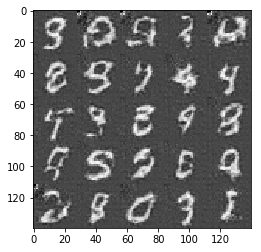

Epoch 2/2... Discriminator Loss: 0.4361... Generator Loss: 4.4125
Epoch 2/2... Discriminator Loss: 0.8615... Generator Loss: 1.9091
Epoch 2/2... Discriminator Loss: 0.7452... Generator Loss: 1.6858
Epoch 2/2... Discriminator Loss: 1.1307... Generator Loss: 3.0961
Epoch 2/2... Discriminator Loss: 0.7646... Generator Loss: 1.9536
Epoch 2/2... Discriminator Loss: 0.8393... Generator Loss: 2.0831
Epoch 2/2... Discriminator Loss: 0.4398... Generator Loss: 3.5190
Epoch 2/2... Discriminator Loss: 2.9340... Generator Loss: 4.4755
Epoch 2/2... Discriminator Loss: 0.7928... Generator Loss: 1.4604
Epoch 2/2... Discriminator Loss: 0.7286... Generator Loss: 1.6504


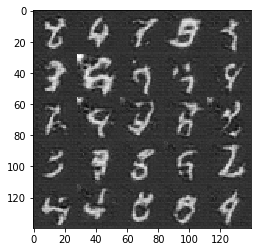

Epoch 2/2... Discriminator Loss: 0.6787... Generator Loss: 2.6923
Epoch 2/2... Discriminator Loss: 0.7338... Generator Loss: 1.5899
Epoch 2/2... Discriminator Loss: 0.5632... Generator Loss: 2.7527
Epoch 2/2... Discriminator Loss: 2.3206... Generator Loss: 3.2531
Epoch 2/2... Discriminator Loss: 0.7929... Generator Loss: 1.7653
Epoch 2/2... Discriminator Loss: 0.4480... Generator Loss: 2.9273
Epoch 2/2... Discriminator Loss: 0.6499... Generator Loss: 2.2973
Epoch 2/2... Discriminator Loss: 0.7220... Generator Loss: 5.3900
Epoch 2/2... Discriminator Loss: 0.4456... Generator Loss: 4.0498
Epoch 2/2... Discriminator Loss: 0.8717... Generator Loss: 1.9430


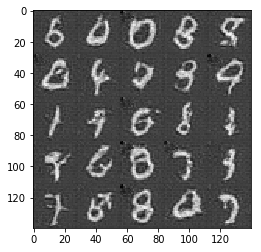

Epoch 2/2... Discriminator Loss: 0.8295... Generator Loss: 1.4578
Epoch 2/2... Discriminator Loss: 1.1310... Generator Loss: 0.8022
Epoch 2/2... Discriminator Loss: 0.7255... Generator Loss: 2.3595
Epoch 2/2... Discriminator Loss: 0.5225... Generator Loss: 2.9800
Epoch 2/2... Discriminator Loss: 0.6250... Generator Loss: 2.9031
Epoch 2/2... Discriminator Loss: 0.5295... Generator Loss: 3.3451
Epoch 2/2... Discriminator Loss: 2.3763... Generator Loss: 2.7660
Epoch 2/2... Discriminator Loss: 0.8759... Generator Loss: 1.5139
Epoch 2/2... Discriminator Loss: 0.7355... Generator Loss: 1.3824
Epoch 2/2... Discriminator Loss: 1.6589... Generator Loss: 0.5225


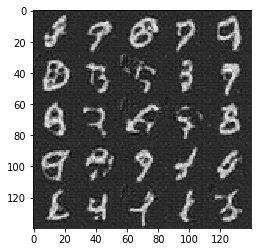

In [14]:
batch_size = 128
z_dim = 128
learning_rate = 1.e-3
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 1.2782
Epoch 1/1... Discriminator Loss: 0.6524... Generator Loss: 1.5793
Epoch 1/1... Discriminator Loss: 0.8511... Generator Loss: 1.3919
Epoch 1/1... Discriminator Loss: 0.7636... Generator Loss: 1.5541
Epoch 1/1... Discriminator Loss: 0.7444... Generator Loss: 2.2407
Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 1.6473
Epoch 1/1... Discriminator Loss: 0.5659... Generator Loss: 2.1200
Epoch 1/1... Discriminator Loss: 0.5736... Generator Loss: 2.5007
Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 2.0669
Epoch 1/1... Discriminator Loss: 0.4791... Generator Loss: 2.9373


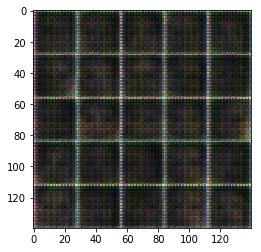

Epoch 1/1... Discriminator Loss: 0.4028... Generator Loss: 3.9993
Epoch 1/1... Discriminator Loss: 0.5167... Generator Loss: 4.8286
Epoch 1/1... Discriminator Loss: 0.6123... Generator Loss: 1.5477
Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 1.3802
Epoch 1/1... Discriminator Loss: 0.5007... Generator Loss: 2.2218
Epoch 1/1... Discriminator Loss: 0.6185... Generator Loss: 1.4842
Epoch 1/1... Discriminator Loss: 0.4014... Generator Loss: 3.8720
Epoch 1/1... Discriminator Loss: 0.3644... Generator Loss: 4.6871
Epoch 1/1... Discriminator Loss: 0.4362... Generator Loss: 4.1990
Epoch 1/1... Discriminator Loss: 0.4708... Generator Loss: 3.2426


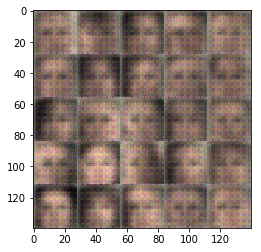

Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 0.5847... Generator Loss: 1.5969
Epoch 1/1... Discriminator Loss: 0.5554... Generator Loss: 1.9808
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 0.3739... Generator Loss: 4.7928
Epoch 1/1... Discriminator Loss: 0.6467... Generator Loss: 1.4512
Epoch 1/1... Discriminator Loss: 0.6741... Generator Loss: 1.3200
Epoch 1/1... Discriminator Loss: 1.9810... Generator Loss: 8.2905
Epoch 1/1... Discriminator Loss: 0.4156... Generator Loss: 5.6968


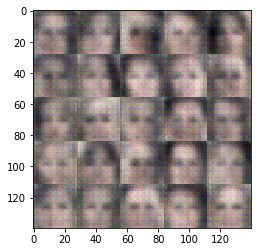

Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 4.4267
Epoch 1/1... Discriminator Loss: 1.7056... Generator Loss: 0.3208
Epoch 1/1... Discriminator Loss: 0.7621... Generator Loss: 1.4556
Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 2.3143
Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 1.6681
Epoch 1/1... Discriminator Loss: 0.5727... Generator Loss: 1.7455
Epoch 1/1... Discriminator Loss: 0.5229... Generator Loss: 5.5331
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 2.8545
Epoch 1/1... Discriminator Loss: 0.6226... Generator Loss: 3.2319
Epoch 1/1... Discriminator Loss: 0.6506... Generator Loss: 1.5560


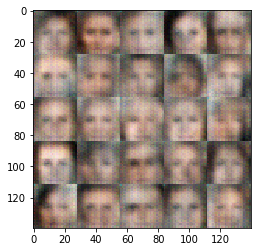

Epoch 1/1... Discriminator Loss: 0.5508... Generator Loss: 3.2391
Epoch 1/1... Discriminator Loss: 0.6657... Generator Loss: 5.5903
Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 3.9967
Epoch 1/1... Discriminator Loss: 0.5267... Generator Loss: 1.8691
Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 2.6649
Epoch 1/1... Discriminator Loss: 0.6189... Generator Loss: 7.2386
Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 1.5118
Epoch 1/1... Discriminator Loss: 0.4790... Generator Loss: 8.0033
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 6.1938
Epoch 1/1... Discriminator Loss: 0.5578... Generator Loss: 7.2712


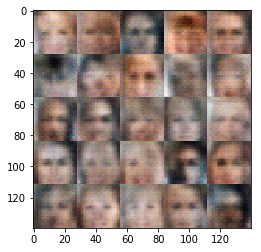

Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.4725
Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 1.5252
Epoch 1/1... Discriminator Loss: 0.4264... Generator Loss: 2.8882
Epoch 1/1... Discriminator Loss: 0.3370... Generator Loss: 6.4018
Epoch 1/1... Discriminator Loss: 0.6710... Generator Loss: 5.2893
Epoch 1/1... Discriminator Loss: 0.3537... Generator Loss: 5.1827
Epoch 1/1... Discriminator Loss: 0.4202... Generator Loss: 3.2508
Epoch 1/1... Discriminator Loss: 0.3774... Generator Loss: 10.0348
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.5542


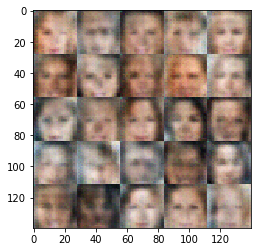

Epoch 1/1... Discriminator Loss: 0.3550... Generator Loss: 4.0597
Epoch 1/1... Discriminator Loss: 0.3881... Generator Loss: 3.5180
Epoch 1/1... Discriminator Loss: 0.3827... Generator Loss: 3.6951
Epoch 1/1... Discriminator Loss: 0.3616... Generator Loss: 5.0439
Epoch 1/1... Discriminator Loss: 0.3838... Generator Loss: 6.8016
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 5.2122
Epoch 1/1... Discriminator Loss: 0.3500... Generator Loss: 4.7152
Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 8.6266


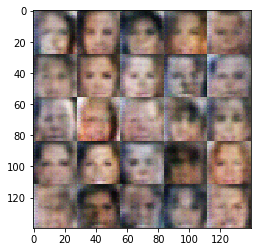

Epoch 1/1... Discriminator Loss: 0.3634... Generator Loss: 3.9906
Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 3.0957
Epoch 1/1... Discriminator Loss: 0.4419... Generator Loss: 3.5507
Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 9.1639
Epoch 1/1... Discriminator Loss: 0.3419... Generator Loss: 5.6072
Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 5.9156
Epoch 1/1... Discriminator Loss: 0.3453... Generator Loss: 7.2389
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 0.6773... Generator Loss: 6.4483
Epoch 1/1... Discriminator Loss: 0.5546... Generator Loss: 2.0787


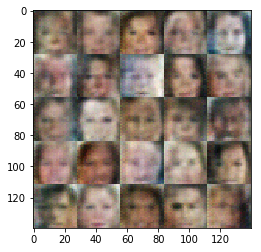

Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 3.0339
Epoch 1/1... Discriminator Loss: 0.5241... Generator Loss: 1.8949
Epoch 1/1... Discriminator Loss: 0.3390... Generator Loss: 5.9459
Epoch 1/1... Discriminator Loss: 0.7582... Generator Loss: 6.1185
Epoch 1/1... Discriminator Loss: 0.4987... Generator Loss: 11.4791
Epoch 1/1... Discriminator Loss: 1.7440... Generator Loss: 0.3179
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 2.7615
Epoch 1/1... Discriminator Loss: 0.5710... Generator Loss: 2.0037
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 0.7678


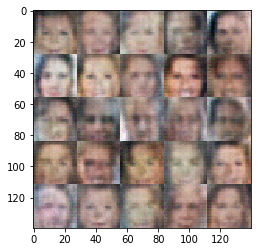

Epoch 1/1... Discriminator Loss: 0.3593... Generator Loss: 5.7897
Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 7.0012
Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 7.6152
Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 9.9465
Epoch 1/1... Discriminator Loss: 0.3557... Generator Loss: 4.2843
Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 7.3513
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 9.5737
Epoch 1/1... Discriminator Loss: 0.3438... Generator Loss: 6.2708
Epoch 1/1... Discriminator Loss: 0.3744... Generator Loss: 5.7105
Epoch 1/1... Discriminator Loss: 0.3539... Generator Loss: 5.2518


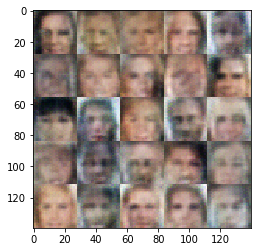

Epoch 1/1... Discriminator Loss: 0.6260... Generator Loss: 5.8509
Epoch 1/1... Discriminator Loss: 0.4122... Generator Loss: 3.3744
Epoch 1/1... Discriminator Loss: 0.3354... Generator Loss: 7.5108
Epoch 1/1... Discriminator Loss: 0.3827... Generator Loss: 5.8182
Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 5.6302
Epoch 1/1... Discriminator Loss: 0.6330... Generator Loss: 4.7984
Epoch 1/1... Discriminator Loss: 0.5107... Generator Loss: 4.2153
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 3.4840
Epoch 1/1... Discriminator Loss: 0.4065... Generator Loss: 4.9755


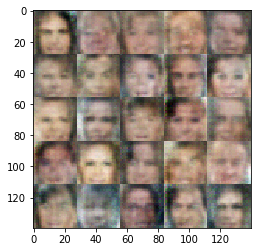

Epoch 1/1... Discriminator Loss: 0.5663... Generator Loss: 1.8609
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 3.6618
Epoch 1/1... Discriminator Loss: 0.3751... Generator Loss: 4.1832
Epoch 1/1... Discriminator Loss: 0.5127... Generator Loss: 9.1421
Epoch 1/1... Discriminator Loss: 0.7064... Generator Loss: 1.2553
Epoch 1/1... Discriminator Loss: 0.3444... Generator Loss: 9.1569
Epoch 1/1... Discriminator Loss: 0.4093... Generator Loss: 3.4283
Epoch 1/1... Discriminator Loss: 0.5209... Generator Loss: 5.5071
Epoch 1/1... Discriminator Loss: 0.4586... Generator Loss: 3.9684
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 3.5335


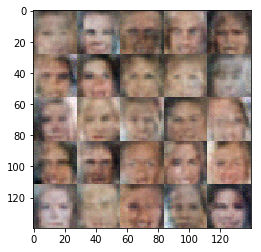

Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 0.6383... Generator Loss: 1.8039
Epoch 1/1... Discriminator Loss: 0.5105... Generator Loss: 2.1623
Epoch 1/1... Discriminator Loss: 0.4368... Generator Loss: 2.9413
Epoch 1/1... Discriminator Loss: 2.0384... Generator Loss: 0.2275
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 0.6656... Generator Loss: 1.5406
Epoch 1/1... Discriminator Loss: 0.8668... Generator Loss: 1.1682
Epoch 1/1... Discriminator Loss: 0.5116... Generator Loss: 4.1570


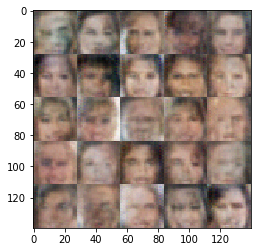

Epoch 1/1... Discriminator Loss: 0.3610... Generator Loss: 5.0443
Epoch 1/1... Discriminator Loss: 0.4821... Generator Loss: 2.7026
Epoch 1/1... Discriminator Loss: 0.3923... Generator Loss: 6.3582
Epoch 1/1... Discriminator Loss: 0.4941... Generator Loss: 2.3055
Epoch 1/1... Discriminator Loss: 0.6559... Generator Loss: 1.5181
Epoch 1/1... Discriminator Loss: 0.3966... Generator Loss: 4.0131
Epoch 1/1... Discriminator Loss: 0.3820... Generator Loss: 6.4902
Epoch 1/1... Discriminator Loss: 0.4102... Generator Loss: 3.0630
Epoch 1/1... Discriminator Loss: 1.8407... Generator Loss: 0.3030
Epoch 1/1... Discriminator Loss: 0.5832... Generator Loss: 5.2637


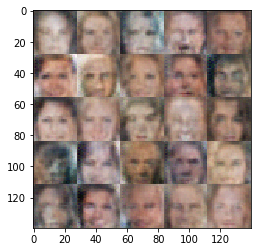

Epoch 1/1... Discriminator Loss: 0.6418... Generator Loss: 1.4902
Epoch 1/1... Discriminator Loss: 0.5183... Generator Loss: 5.6342
Epoch 1/1... Discriminator Loss: 0.4613... Generator Loss: 2.5702
Epoch 1/1... Discriminator Loss: 0.4417... Generator Loss: 3.0004
Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 2.7269
Epoch 1/1... Discriminator Loss: 0.3901... Generator Loss: 4.0085
Epoch 1/1... Discriminator Loss: 0.5369... Generator Loss: 2.2749
Epoch 1/1... Discriminator Loss: 0.3938... Generator Loss: 5.1665
Epoch 1/1... Discriminator Loss: 0.4046... Generator Loss: 6.8009
Epoch 1/1... Discriminator Loss: 0.5092... Generator Loss: 2.6977


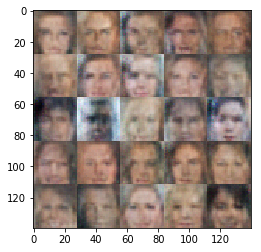

Epoch 1/1... Discriminator Loss: 0.6481... Generator Loss: 4.9369
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 4.7851
Epoch 1/1... Discriminator Loss: 0.8433... Generator Loss: 4.6453
Epoch 1/1... Discriminator Loss: 0.5267... Generator Loss: 6.5845
Epoch 1/1... Discriminator Loss: 0.6201... Generator Loss: 5.7212
Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 1.5453
Epoch 1/1... Discriminator Loss: 0.5788... Generator Loss: 2.6548


KeyboardInterrupt: 

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 1.e-4
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.